# Combined Analysis: SST and Cyclone Wind Speed

### Step 1: Call in Data Created in Prior Steps and Merge

We will pull in cyclone_max_wind.parquet and sst.parquet

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

In [5]:
ds_CS_GM_max = pl.read_parquet('../.data/cyclone_max_wind.parquet')
mean_sst = pl.read_parquet('../.data/sst.parquet').drop('valid_time')

In [12]:
CS_GM_max_sst = (
    ds_CS_GM_max
    .join(
        mean_sst,
        on=['month','year'],
        how='left'
    )
)
CS_GM_max_sst.head(5)

storm,date_time,lon,lat,usa_wind,usa_sshs,time,sid,storm_speed,subbasin,year,month,sst
i64,i64,f32,f32,f32,f32,datetime[ns],binary,f32,binary,i32,i8,f32
0,13,-94.699997,27.700001,92.062393,1.0,1851-06-25 03:00:00.000040224,"b""1851175N26270""",8.0,"b""GM""",1851,6,null
2,0,-97.599998,22.200001,92.062393,1.0,1851-07-05 12:00:00.000040224,"b""1851187N22262""",null,"b""GM""",1851,7,null
3,0,-60.0,12.0,57.538998,0.0,1851-07-10 12:00:00.000040224,"b""1851192N12300""",null,"b""CS""",1851,7,null
5,59,-86.5,28.299999,115.077995,3.0,1851-08-23 09:00:00.000040224,"b""1851228N13313""",5.0,"b""GM""",1851,8,null
9,49,-88.0,28.299999,115.077995,3.0,1852-08-25 03:00:00.000040224,"b""1852232N21293""",4.0,"b""GM""",1852,8,null


### Step 2: Filter for Data 1940+

This is the time that the SST reanalysis data is available

In [ ]:
CS_GM_max_sst = CS_GM_max_sst.filter(pl.col('year') >= 1940)
CS_GM_max_sst

storm,date_time,lon,lat,usa_wind,usa_sshs,time,sid,storm_speed,subbasin,year,month,sst
i64,i64,f32,f32,f32,f32,datetime[ns],binary,f32,binary,i32,i8,f32
507,35,-94.099998,29.700001,97.816299,2.0,1940-08-07 21:00:00.000040448,"b""1940217N29277""",5.0,"b""GM""",1940,8,28.682373
508,0,-64.800003,18.9,46.031197,0.0,1940-08-05 18:00:00.000040448,"b""1940219N19295""",15.0,"b""CS""",1940,8,28.682373
509,20,-87.400002,17.9,51.785099,0.0,1940-09-21 00:00:00.000040448,"b""1940263N12279""",10.0,"b""CS""",1940,9,28.681183
510,26,-82.400002,14.1,80.554596,1.0,1940-10-23 06:00:00.000040448,"b""1940294N12281""",3.0,"b""CS""",1940,10,28.257568
511,16,-89.599998,27.9,57.538998,0.0,1941-09-13 00:00:00.000040448,"b""1941254N27273""",3.0,"b""GM""",1941,9,28.693359
…,…,…,…,…,…,…,…,…,…,…,…,…
1103,22,-96.699997,20.9,46.031197,0.0,2025-06-29 18:00:00.000039936,"b""2025178N17274""",10.0,"b""GM""",2025,6,28.509094
1104,0,-83.0,26.299999,17.2617,-3.0,2025-07-03 06:00:00.000039936,"b""2025184N26277""",13.0,"b""GM""",2025,7,28.715576
1105,8,-61.400002,17.0,28.769499,-3.0,2025-09-23 12:00:00.000039936,"b""2025266N16305""",9.0,"b""CS""",2025,9,29.534851


### Step 3: Analyze Data

Use the available data to see if there exists a relationship between sea surface temperature and storm wind speed

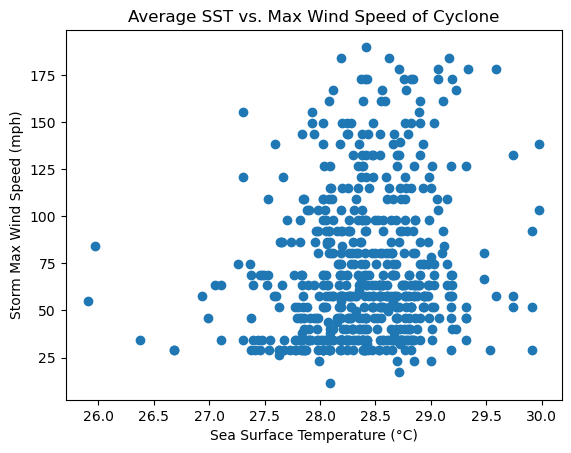

Correlation Between Max Wind Speed and SST: 0.1706


In [28]:
plt.scatter(CS_GM_max_sst['sst'], CS_GM_max_sst['usa_wind'])
plt.xlabel('Sea Surface Temperature (°C)')
plt.ylabel('Storm Max Wind Speed (mph)')
plt.title('Average SST vs. Max Wind Speed of Cyclone')
plt.show()
print(
    "Correlation Between Max Wind Speed and SST:",
    np.round(np.corrcoef(CS_GM_max_sst['sst'],CS_GM_max_sst['usa_wind'])[1,0],4)
)

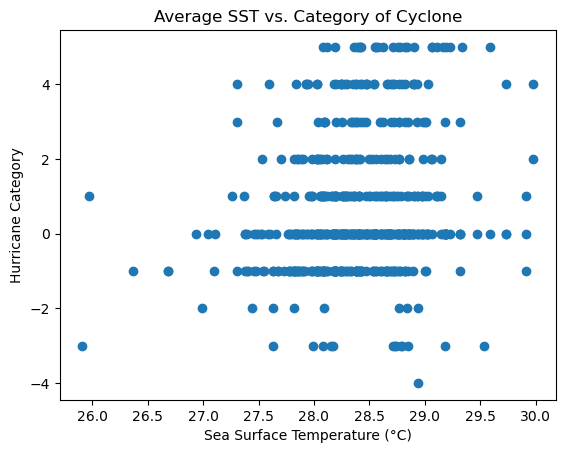

Correlation Between Cyclone Category and SST: 0.1798


In [29]:
plt.scatter(CS_GM_max_sst['sst'], CS_GM_max_sst['usa_sshs'])
plt.xlabel('Sea Surface Temperature (°C)')
plt.ylabel('Hurricane Category')
plt.title('Average SST vs. Category of Cyclone')
plt.show()
print(
    "Correlation Between Cyclone Category and SST:",
    np.round(np.corrcoef(CS_GM_max_sst['sst'],CS_GM_max_sst['usa_sshs'])[1,0],4)
)

### Step 4: Isolate SST in GLM

Let's fit a GLM model where we hold constant month to see if SST has an effect outside of the natural variations we see by month

In [35]:
glm_fitting_data = (
    CS_GM_max_sst
    .with_columns(
        pl.when(pl.col('month') == 5)
        .then(1)
        .otherwise(0)
        .alias('month_5'),
        pl.when(pl.col('month') == 6)
        .then(1)
        .otherwise(0)
        .alias('month_6'),
        pl.when(pl.col('month') == 7)
        .then(1)
        .otherwise(0)
        .alias('month_7'),
        pl.when(pl.col('month') == 8)
        .then(1)
        .otherwise(0)
        .alias('month_8'),
        pl.when(pl.col('month') == 9)
        .then(1)
        .otherwise(0)
        .alias('month_9'),
        pl.when(pl.col('month') == 10)
        .then(1)
        .otherwise(0)
        .alias('month_10'),
        pl.when(pl.col('month') == 11)
        .then(1)
        .otherwise(0)
        .alias('month_11')
    )
    .select('usa_wind',
            'sst',
            'month_5',
            'month_6',
            'month_7',
            'month_8',
            'month_9',
            'month_10',
            'month_11',
            'year')
)
glm_fitting_data.head(5)

usa_wind,sst,month_5,month_6,month_7,month_8,month_9,month_10,month_11,year
f32,f32,i32,i32,i32,i32,i32,i32,i32,i32
97.816299,28.682373,0,0,0,1,0,0,0,1940
46.031197,28.682373,0,0,0,1,0,0,0,1940
51.785099,28.681183,0,0,0,0,1,0,0,1940
80.554596,28.257568,0,0,0,0,0,1,0,1940
57.538998,28.693359,0,0,0,0,1,0,0,1941


In [37]:
formula = 'usa_wind ~ sst + year + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11'
model_combined = smf.ols(formula=formula, data=glm_fitting_data).fit()
residuals = model_combined.resid
fitted_values = model_combined.fittedvalues
model_combined.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               usa_wind   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     5.478
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           3.00e-07
Time:                        17:51:27   Log-Likelihood:                -3026.3
No. Observations:                 601   AIC:                             6073.
Df Residuals:                     591   BIC:                             6117.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -238.4282    130.587     -1.826      0.068    -494.899      18.042
sst           11.4578      4.804      2.385      0.017       2.022      20.893
year          -0.0076      0.077     -0.098      0.922      -0.159       0.144
month_5      -19.9798     18.312     -1.091      0.276     -55.945      15.985
month_6      -14.6527     16.626     -0.881      0.379     -47.307      18.002
month_7      -11.9159     17.099     -0.697      0.486     -45.498      21.666
month_8       -1.7078     17.510     -0.098      0.922     -36.097      32.682
month_9        2.2228     17.678      0.126      0.900     -32.496      36.942
month_10       6.3958     17.096      0.374      0.708     -27.180      39.971
month_11      17.2083     16.551      1.040      0.299     -15.297      49.713
==============================================================================
Omnibus:                       67.863   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.099
Skew:                           0.936   Prob(JB):                     4.49e-20
Kurtosis:                       3.228   Cond. No.                     1.69e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see a significant level relationship between SST and Max Wind Speed when holding the year and months constant (reject null hypothesis at 5% level) with a **p-value of 0.017**

### Step 5: Additional Analysis -- Breakdown of Overall Graph by Month

In [40]:
def month_graph(month_num):
    temp_data = CS_GM_max_sst.filter(pl.col('month') == month_num)
    plt.scatter(temp_data['sst'], temp_data['usa_wind'])
    plt.xlabel('Sea Surface Temperature (°C)')
    plt.ylabel('Storm Max Wind Speed (mph)')
    plt.title(f'Average SST vs. Max Wind Speed of Cyclone, Month = {month_num}')
    plt.show()
    print(
        "Correlation Between Max Wind Speed and SST:",
        np.round(np.corrcoef(temp_data['sst'],temp_data['usa_wind'])[1,0],4)
    )

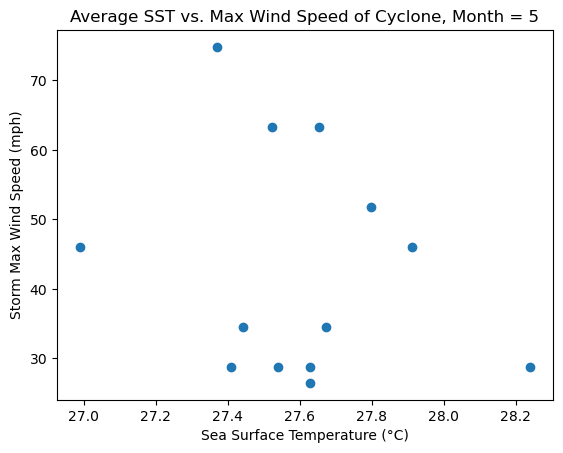

Correlation Between Max Wind Speed and SST: -0.2196


In [41]:
month_graph(5)

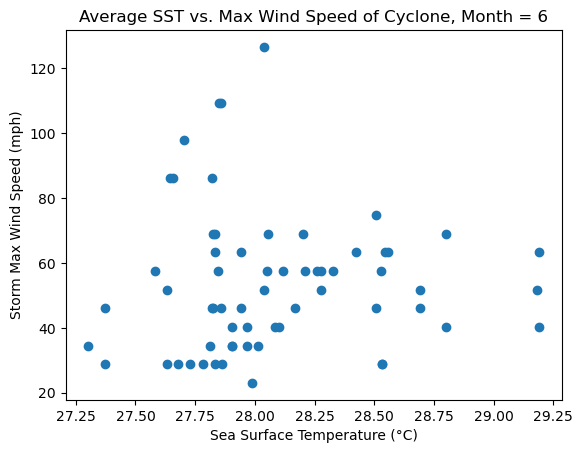

Correlation Between Max Wind Speed and SST: 0.0183


In [43]:
month_graph(6)

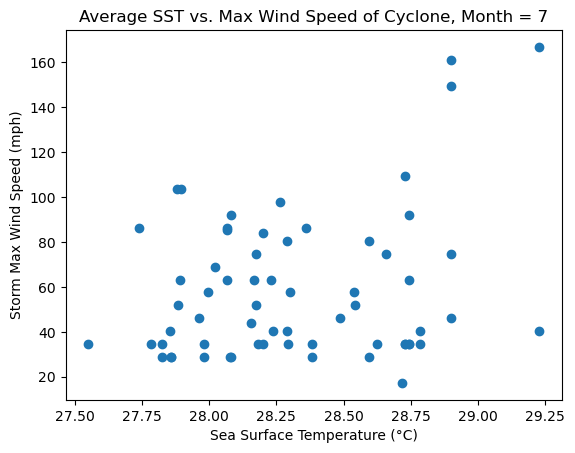

Correlation Between Max Wind Speed and SST: 0.2547


In [44]:
month_graph(7)

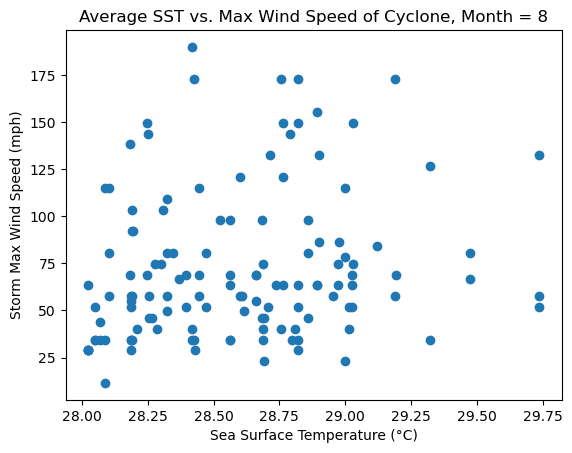

Correlation Between Max Wind Speed and SST: 0.1913


In [45]:
month_graph(8)

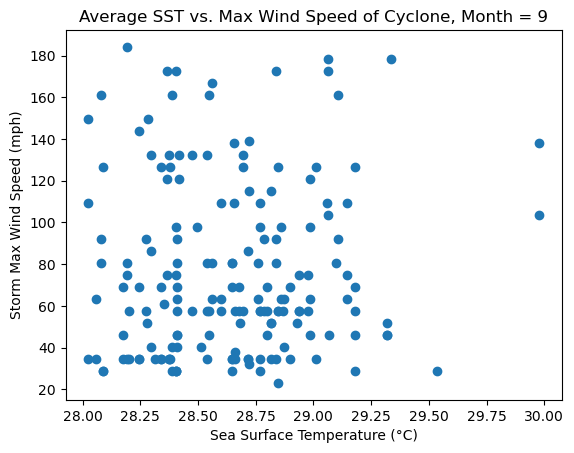

Correlation Between Max Wind Speed and SST: 0.047


In [46]:
month_graph(9)

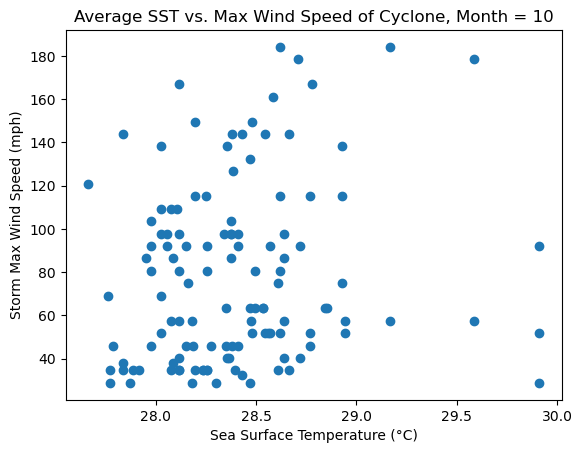

Correlation Between Max Wind Speed and SST: 0.1404


In [47]:
month_graph(10)

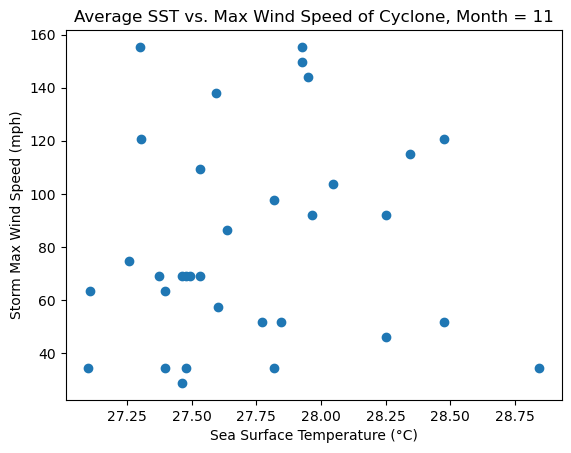

Correlation Between Max Wind Speed and SST: 0.105


In [48]:
month_graph(11)

The graphs show that the correlation is stronger for the most frequent cyclone season -- August.